
The CartPole environment from OpenAI Gym is a classic control problem used to benchmark reinforcement learning algorithms.

**Goal:** The goal is to balance a pole, which is attached by an un-actuated joint to a cart, for as long as possible.  The cart moves along a frictionless track.  The agent must apply a force to the cart (either pushing left or right) to keep the pole upright.


<img src="https://aleksandarhaber.com/wp-content/uploads/2023/01/sketch-1-1024x608.png" width="720">



**State:** The environment provides the following four state variables at each time step:

1. **Cart Position:** The horizontal position of the cart along the track.
2. **Cart Velocity:** The velocity of the cart.
3. **Pole Angle:** The angle of the pole with respect to the vertical.  This is the crucial variable; a large angle indicates an imminent fall.
4. **Pole Angular Velocity:** The rate at which the pole's angle is changing.


**Actions:**  The agent can take one of two discrete actions at each time step:

1. **Push cart to the left:** Apply a force to move the cart left.
2. **Push cart to the right:** Apply a force to move the cart right.


**Reward:** The agent receives a reward of +1 for every time step the pole remains upright.  The episode ends when:

* **Pole Angle Exceeds Threshold:** The pole tilts too far from the vertical.
* **Cart Position Exceeds Threshold:** The cart moves too far to the left or right.
* **Episode Length Limit:** A maximum number of time steps is reached (a common limit is 500).


**Difficulty:**  The challenge lies in learning a policy that balances the pole for an extended period.  Small mistakes in applying forces can quickly lead to the pole falling.


In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image, display
import random

random.seed(42)
np.random.seed(42)

# Discretization function for continuous states
def discretize_state(state, bins):
    state_index = []
    for i, value in enumerate(state):
        state_index.append(np.digitize(value, bins[i]) - 1)  # Bin indices start at 0
    return tuple(state_index)

In [ ]:
# Q-learning agent
class QLearningAgent:
    def __init__(self, env, bins, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.bins = bins
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Desired range for cart velocity and pole angular velocity
        clip_ranges = {
            1: [-5.0, 5.0],  # For cart velocity (index 1)
            3: [-5.0, 5.0],  # For pole angular velocity (index 3)
        }

        # Create bins for discretization with clipping
        self.bin_edges = [np.linspace(clip_ranges[i][0], clip_ranges[i][1], bins[i] + 1)[1:-1] if i in clip_ranges
                          else np.linspace(env.observation_space.low[i], env.observation_space.high[i], bins[i] + 1)[1:-1]
                          for i in range(env.observation_space.shape[0])
                          ]

        # Initialize Q-table
        self.q_table = np.zeros(bins + (env.action_space.n,))

    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy."""
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        state_index = discretize_state(state, self.bin_edges)
        return np.argmax(self.q_table[state_index])

    def update_q(self, state, action, reward, next_state, done):
        """Update the Q-value based on the Q-learning update rule."""
        state_index = discretize_state(state, self.bin_edges)
        next_state_index = discretize_state(next_state, self.bin_edges)

        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.gamma * self.q_table[next_state_index][best_next_action] * (not done)
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.alpha * td_error

In [ ]:
# Training and evaluation
def train_agent(agent, episodes, max_steps=200):
    rewards = []
    for episode in range(episodes):
        state = agent.env.reset()
        total_reward = 0
        for step in range(max_steps):
            action = agent.choose_action(state)
            next_state, reward, done, _ = agent.env.step(action)
            agent.update_q(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
        if (episode + 1) % 1000 == 0:
            print(f"Episode {episode + 1}: Aveare Reward over last 10 iterations = {np.mean(rewards[:-10])}")
    return rewards

In [ ]:
def evaluate_agent(agent, episodes, max_steps=200):
    rewards = []
    for _ in range(episodes):
        state = agent.env.reset()
        total_reward = 0
        for step in range(max_steps):
            state_index = discretize_state(state, agent.bin_edges)
            action = np.argmax(agent.q_table[state_index])
            state, reward, done, _ = agent.env.step(action)
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
    return np.mean(rewards)

In [ ]:
# Save GIF of the agent's performance
def save_agent_gif(agent, filename="cartpole_qlearning.gif", max_steps=200):
    frames = []
    state = agent.env.reset()
    for step in range(max_steps):
        # Capture the current frame
        frames.append(agent.env.render(mode="rgb_array"))
        state_index = discretize_state(state, agent.bin_edges)
        action = np.argmax(agent.q_table[state_index])
        state, _, done, _ = agent.env.step(action)
        if done:
            break
    agent.env.close()

    # Save the frames as a GIF with looping enabled
    imageio.mimsave(filename, frames, fps=30, loop=0)
    print(f"Saved performance as {filename}")

In [ ]:
# Play the GIF in Colab
def play_gif(filename):
    display(Image(filename=filename))

In [ ]:
# Function to run and log one experiment with specific bins
def run_experiment(bins, env_name="CartPole-v1", episodes=1000, max_steps=200):
    env = gym.make(env_name)
    print(f"Observation space low: {env.observation_space.low}")
    print(f"Observation space high: {env.observation_space.high}")
    print(f"Running experiment with bins: {bins} per state dimension")

    agent = QLearningAgent(env, bins=(bins, bins, bins, bins), alpha=0.05, gamma=0.99, epsilon=0.1)

    # Train agent
    train_rewards = train_agent(agent, episodes, max_steps)

    # Save GIF for this bin configuration
    gif_filename = f"cartpole_bins_{bins}.gif"
    save_agent_gif(agent, filename=gif_filename)
    play_gif(gif_filename)

    # Calculate average reward
    avg_reward = evaluate_agent(agent, episodes=20, max_steps=max_steps)
    q_table_size = agent.q_table.size

    print(f"Average reward over 10 episodes: {avg_reward}")
    print(f"Q-table size: {q_table_size}")
    return bins, avg_reward, q_table_size

In [ ]:
# Final plotting after all experiments
def plot_results(results):
    bins, avg_rewards, q_table_sizes = zip(*results)

    plt.figure(figsize=(12, 6))

    # Plot performance vs. bins
    plt.subplot(1, 2, 1)
    plt.plot(bins, avg_rewards, marker="o", label="Performance")
    plt.title("Performance vs. Number of Bins")
    plt.xlabel("Number of Bins per State Dimension")
    plt.ylabel("Average Reward")
    plt.grid()
    plt.legend()

    # Plot number of bins vs. Q-table size
    plt.subplot(1, 2, 2)
    plt.plot(bins, q_table_sizes, marker="o", color="orange", label="Q-table Entries")
    plt.title("Number of Bins vs. Q-table Size")
    plt.xlabel("Number of Bins per State Dimension")
    plt.ylabel("Q-table Size")
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()


Observation space low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Observation space high: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Running experiment with bins: 2 per state dimension
Episode 1000: Aveare Reward over last 10 iterations = 41.70808080808081
Episode 2000: Aveare Reward over last 10 iterations = 57.66281407035176
Episode 3000: Aveare Reward over last 10 iterations = 67.15384615384616
Episode 4000: Aveare Reward over last 10 iterations = 68.76741854636592
Episode 5000: Aveare Reward over last 10 iterations = 71.1376753507014
Saved performance as cartpole_bins_2.gif


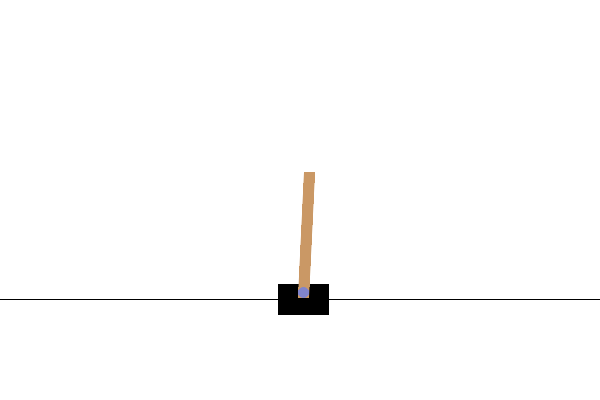

Average reward over 10 episodes: 69.05
Q-table size: 32


In [ ]:
results = []
bins = 2
_, avg_reward, q_table_size = run_experiment(bins, max_steps=500, episodes=5000)
results.append((bins, avg_reward, q_table_size))

Observation space low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Observation space high: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Running experiment with bins: 4 per state dimension
Episode 1000: Aveare Reward over last 10 iterations = 27.817171717171718
Episode 2000: Aveare Reward over last 10 iterations = 57.08291457286432
Episode 3000: Aveare Reward over last 10 iterations = 69.21103678929767
Episode 4000: Aveare Reward over last 10 iterations = 72.87218045112782
Episode 5000: Aveare Reward over last 10 iterations = 74.47254509018036
Saved performance as cartpole_bins_4.gif


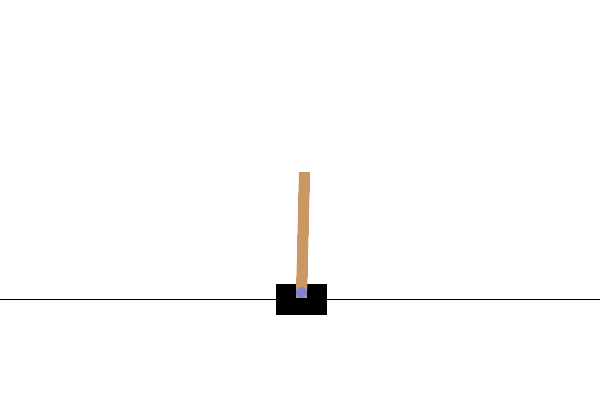

Average reward over 10 episodes: 131.05
Q-table size: 512


In [ ]:
bins = 4
_, avg_reward, q_table_size = run_experiment(bins, max_steps=500, episodes=5000)
results.append((bins, avg_reward, q_table_size))

Observation space low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Observation space high: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Running experiment with bins: 6 per state dimension
Episode 1000: Aveare Reward over last 10 iterations = 20.719191919191918
Episode 2000: Aveare Reward over last 10 iterations = 52.09899497487437
Episode 3000: Aveare Reward over last 10 iterations = 82.06187290969899
Episode 4000: Aveare Reward over last 10 iterations = 98.19974937343359
Episode 5000: Aveare Reward over last 10 iterations = 112.41683366733467
Saved performance as cartpole_bins_6.gif


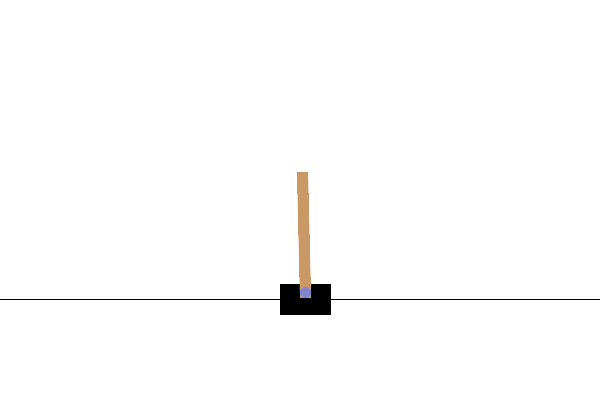

Average reward over 10 episodes: 162.3
Q-table size: 2592


In [ ]:
bins = 6
_, avg_reward, q_table_size = run_experiment(bins, max_steps=500, episodes=5000)
results.append((bins, avg_reward, q_table_size))

Observation space low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Observation space high: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Running experiment with bins: 8 per state dimension
Episode 1000: Aveare Reward over last 10 iterations = 16.14949494949495
Episode 2000: Aveare Reward over last 10 iterations = 44.01356783919598
Episode 3000: Aveare Reward over last 10 iterations = 67.97591973244147
Episode 4000: Aveare Reward over last 10 iterations = 87.3937343358396
Episode 5000: Aveare Reward over last 10 iterations = 100.69819639278558
Saved performance as cartpole_bins_8.gif


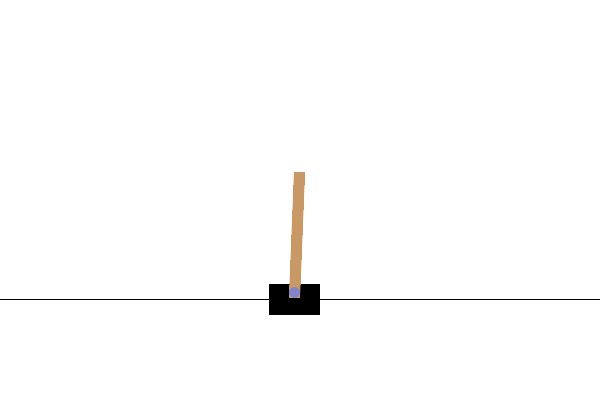

Average reward over 10 episodes: 173.2
Q-table size: 8192


In [ ]:
bins = 8
_, avg_reward, q_table_size = run_experiment(bins, max_steps=500, episodes=5000)
results.append((bins, avg_reward, q_table_size))

Observation space low: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Observation space high: [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Running experiment with bins: 10 per state dimension
Episode 1000: Aveare Reward over last 10 iterations = 13.37070707070707
Episode 2000: Aveare Reward over last 10 iterations = 24.282412060301507
Episode 3000: Aveare Reward over last 10 iterations = 44.92909698996655
Episode 4000: Aveare Reward over last 10 iterations = 70.22756892230576
Episode 5000: Aveare Reward over last 10 iterations = 90.13927855711422
Saved performance as cartpole_bins_10.gif


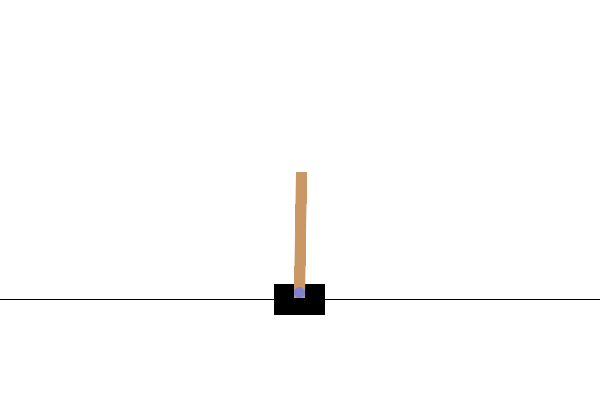

Average reward over 10 episodes: 183.3
Q-table size: 20000


In [ ]:
bins = 10
_, avg_reward, q_table_size = run_experiment(bins, max_steps=500, episodes=5000)
results.append((bins, avg_reward, q_table_size))

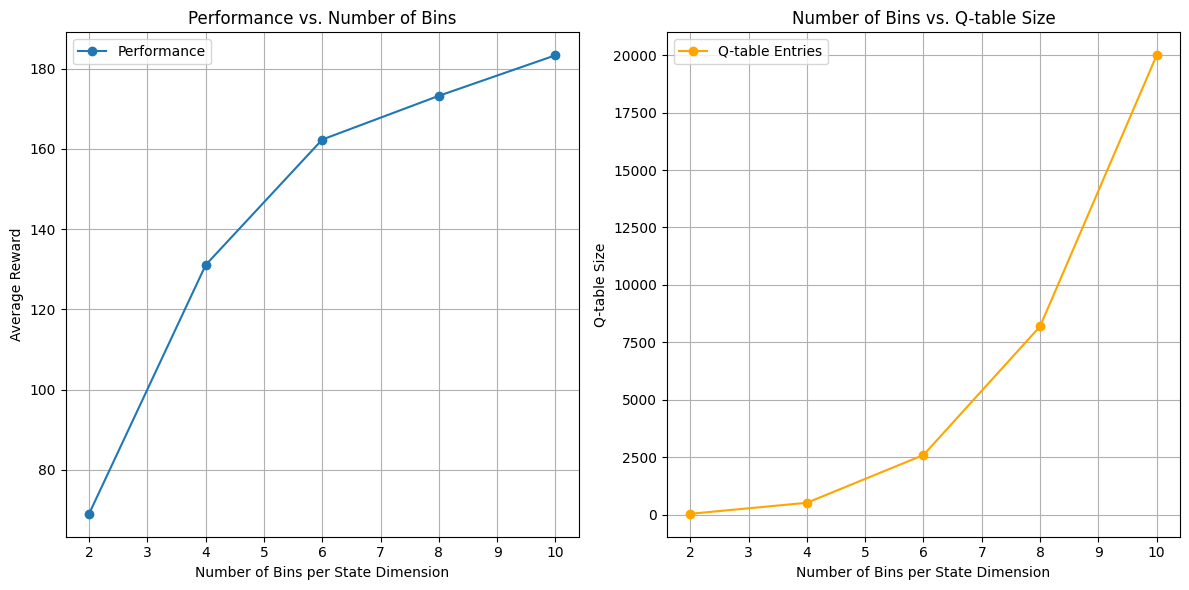

In [ ]:
# Plot results after all experiments
plot_results(results)